In [78]:
# imports
import numpy as np
from numpy import linalg as LA
from random import random
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import combinations, permutations
from scipy.special import comb
from scipy import ndimage as ni

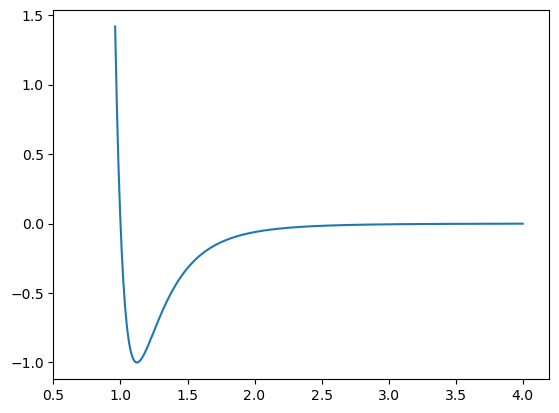

In [7]:
# Plot Lennard Jones Potential (unitless)
x_lj = np.linspace(0.96, 4, 500)
y_lj = 4*((1/x_lj)**12-(1/x_lj)**6)

plt.plot(x_lj, y_lj)
plt.xlim(0.5,4.2)
plt.show()

## System Setup
Verlet reported that he had 864 Argon atoms in the system and using face-centered cubic unit cells.<br>
Face-Centered Cubic has 4 atoms per cell
$$1 \times N_{corner} + 3\times N_{face} = 4N$$
Based on this, we can calculate how many unit cells in total and for each dimension
$$
864 = 4N^3 \\
N^3 = 216 \Rightarrow N = 6
$$
With 6 unit cells per dimension, and we can find out the number of corner atoms and face atoms
$$N_{corner} = 6^3 = 216 \\
N_{face} = 3\times 6^3 = 648$$


In [8]:
n = 6.0221415e23 # /mol
m_argon = 39.948/n # gram

rho = 1.374 # g/cm^3 @ 130K
L_cm = (m_argon*864/rho)**(1/3) # centimeter
L = L_cm *1e-2 # system dimension in angstrom
N_cell = 6 # Unit cell per dimension
cell_len = L/N_cell

In [9]:
x_corner = np.linspace(0, L-cell_len, N_cell) # corner atom spacings
x_face = np.linspace(cell_len/2,L-cell_len/2, N_cell) # face atom spacings

grid_c = np.meshgrid(x_corner, x_corner, x_corner, indexing='ij')
grid_f = np.meshgrid(x_face, x_corner, x_face, indexing='ij')

In [10]:
# get 3 faces by rotating 90 degrees using permutations on the x_corner and x_face.
# select the first 3 items from the permutation, since they coincide with
# the three faces (this is hard code for now)
grid_3f = np.array(tuple(permutations(grid_f))[:3]) 

In [11]:
# Fortran style x, y, z column arrays
face_coords = np.concatenate(grid_3f.reshape(3,3,-1), axis = 1)
corner_coords = np.array(grid_c).reshape(3,-1)
# piece-wise coords array
coords = np.concatenate([face_coords, corner_coords], axis = 1).T
print(corner_coords.shape)
print(face_coords.shape)
print(coords.shape)

(3, 216)
(3, 648)
(864, 3)


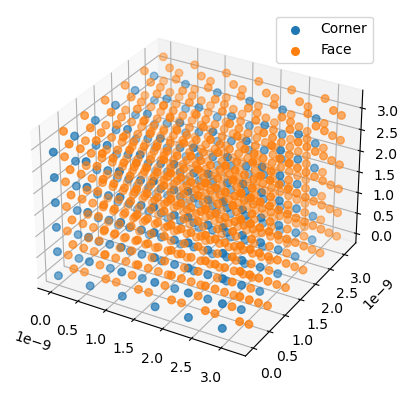

In [12]:
%matplotlib inline
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(*corner_coords, s=30, label='Corner')
ax.scatter(*face_coords, s=30, label='Face')

ax.legend()
plt.show()

## Initial Velocities

Temperature here is a variable <br>
$$T = 120 \; K$$
Other constants
$$
k_B = 1.3806503 \times 10^{-23} \; J/K\\
n = 6.0221415 \times 10^{23} \; mol^{-1}\\
m_{Ar} = 39.948 \; g/mol
$$
Standard deviation of velocity is given by
$$
\sigma = \sqrt{\frac{k_B T}{m_{Ar}}}
$$
We can plugin the numbers for $\sigma$ and do a dimension anaylsis
$$
\frac{k_B T}{m_{Ar}} = 
\frac{1.3806503 \times 10^{-23}J/K \times 120K }{39.948 g/mol \times 10^{-3} kg/g \times \frac{1}{6.0221415 \times 10^{23} mol^{-1}}}\\
= \frac{1.3806503 \times 120 }{39.948 \times 10^{-3} \times 6.0221415^{-1}} \cdot \frac{J}{kg}
$$
The final unit yields velocity squared; therefore, $\sigma$ has the unit of velocity
$$
\frac{J}{kg} = \frac{m^2 \cdot kg \cdot s^{-2}}{kg} = m^2 s^{-2} = \left(\frac{m}{s}\right)^2
$$

In [13]:
temp = 120 # Kelvin
kb = 1.3806503e-23
kbT_over_m = 1.3806503*temp/(39.948e-3*6.0221415**(-1)) # m^2/s^2
std_velo = (kbT_over_m)**0.5 # m/s
delta_t = 1e-14 # sec

std_velo

158.03760012674934

Average speed of the atoms is given by
$$
C_{avg} = \sqrt{\frac{8k_BT}{\pi m}}
$$

In [15]:
c_avg = (8*kbT_over_m/np.pi)**0.5
c_avg

252.19152233494052

We are gonna randomly draw initial velocities from the Gaussian distribution with the $\sigma$ we just calculated for $T=120K$, and we will check if the velocities largely conform to Maxwell-Boltzmann distribution

In [16]:
# initialize velocities
velo = np.random.normal(0, std_velo, coords.shape)
# calculate speeds (vector norm)
speeds = LA.norm(velo, axis = 1)
# find avg speed
speeds.mean()

253.67133311498694

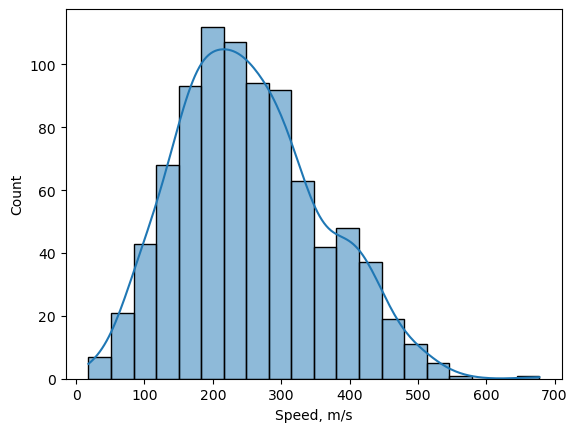

In [17]:
fig, ax = plt.subplots()
sns.histplot(speeds, bins=20, kde=True, ax=ax)
plt.xlabel('Speed, m/s')
plt.show()

In [18]:
def pbc_dist(d_vecs, L):
    mask1 = d_vecs > L/2
    mask2 = d_vecs < -L/2
    new_vecs1 = L - d_vecs[mask1]
    new_vecs2 = L + d_vecs[mask2]
    d_vecs[mask1] = new_vecs1
    d_vecs[mask2] = new_vecs2
    
def pbc_coord(coords, L):
    mask1 = coords > L
    mask2 = coords < 0
    wrapped_coords1 = coords[mask1] % L
    wrapped_coords2 = L - ((-coords[mask2]) % L)
    coords[mask1] = wrapped_coords1
    coords[mask2] = wrapped_coords2

# Verlet algorithm
def verlet(curr_x, last_x, dt, a):
    return 2*(curr_x)-last_x+a*dt**2

# Lennard-Jones system force
# units in J
# epsilon/k_b = 120K => epsilon: J (m^2 kg s^-2)
def lennardjones(r):
    ''' v_LJ(r) = 4e[(σ/r)^12-(σ/4)^6] '''
    return 4*120*kb*((3.4e-10/r)**12-(3.4e-10/r)**6)

In [19]:
def get_accl(coords, combos, L):
    # dist vector from atom j to atom i
    dist_vecs = coords[combos][:,0] - coords[combos][:,1]
    # apply periodic boundary conditions
    pbc_dist(dist_vecs, L)

    # pairwise euclidean distances from atom j to atom i
    r_ij = LA.norm(dist_vecs, axis = 1)

    # 2.5 sigma is set as cutoff
    cutoff_mask = np.logical_and(r_ij<=2.5*3.4e-10, r_ij>0)
    # indices of r_ij that needs to be evaluated
    cutoff_ids = np.nonzero(cutoff_mask)[0]

    # pairwise potentials
    potentials = lennardjones(r_ij[cutoff_ids])
    # pairwise force vectors (x,y,z) from atom j to atom i
    forces = (dist_vecs[cutoff_ids].T * potentials / r_ij[cutoff_ids]).T 

    # indices pair that are within cutoff
    effect_ids = combos[cutoff_ids]
    # force vectors for each atom 
    f_ij = np.zeros(coords.shape)
    for (i, j), f in zip(effect_ids, forces):
        f_ij[i] += f # force j to i
        f_ij[j] -= f # force i to j
        
    # acceleration
    accl = f_ij/(m_argon*1e-3)
    return accl

In [20]:
def init_coords(coords, combos, velo, L, delta_t):
    init_accl = get_accl(coords, combos, L)
    last_coords = coords
    cur_coords = last_coords+velo*delta_t+init_accl*delta_t**2/2
    pbc_coord(cur_coords, L)
    cur_accl = get_accl(cur_coords, combos, L)
    return cur_coords, last_coords, cur_accl

In [21]:
def step(cur_coords, last_coords, delta_t, cur_accl, combos, L):
    new_coords = verlet(cur_coords, last_coords, delta_t, cur_accl)
    velocities = (new_coords - last_coords)/(2*delta_t)
    pbc_coord(new_coords, L)
    cur_accl = get_accl(new_coords, combos, L)
    return new_coords, cur_coords, cur_accl, velocities

In [22]:
# combination of indices (i, j) for atom i and atom j
combos = np.array(list(combinations(range(len(coords)),2)))

In [73]:
# dist vector from atom j to atom i
dist_vecs = coords[combos][:,0] - coords[combos][:,1]
# apply periodic boundary conditions
pbc_dist(dist_vecs, L)

# pairwise euclidean distances from atom j to atom i
r_ij = LA.norm(dist_vecs, axis = 1)

# 2.5 sigma is set as cutoff
cutoff_mask = np.logical_and(r_ij<=2.5*3.4e-10, r_ij>0)
# indices of r_ij that needs to be evaluated
cutoff_ids = np.nonzero(cutoff_mask)[0]

# pairwise potentials
potentials = lennardjones(r_ij[cutoff_ids])
# pairwise force vectors (x,y,z) from atom j to atom i
forces = (dist_vecs[cutoff_ids].T * potentials / r_ij[cutoff_ids]).T 

# indices pair that are within cutoff
effect_ids = combos[cutoff_ids]
# force vectors for each atom 
f_ij = np.zeros(coords.shape)
for i in range(len(f_ij)):
    # force j to i
    f_ij[i] += forces[effect_ids[:,0] == i].sum(0)
    # force i to j
    f_ij[i] -= forces[effect_ids[:,1] == i].sum(0)

# acceleration
accl = f_ij/(m_argon*1e-3)


In [79]:
f_ij2 = f_ij

In [137]:
idx_array = np.arange(coords.shape[0])

In [117]:
fx, fy, fz = forces.T

In [139]:
f_vecs = np.empty(coords.shape)
idx_array = np.arange(coords.shape[0])
fx, fy, fz = forces.T
for i, f in enumerate((fx, fy, fz)):
    f_vecs[:,i] = sum_forces_1d(f, effect_ids, idx_array)

In [140]:
f_vecs

array([[ 2.77416667e-36,  2.84469633e-36,  2.98575565e-36],
       [ 3.00926554e-36,  2.69188206e-36,  4.46687853e-36],
       [ 3.00926554e-36,  3.02102048e-36,  5.31323447e-36],
       ...,
       [-4.29055438e-37, -3.82035664e-37,  0.00000000e+00],
       [-5.67176024e-37, -3.79096928e-37, -1.26953390e-36],
       [-7.52316385e-37, -3.76158192e-37,  0.00000000e+00]])

In [136]:
def sum_forces_1d(forces_1d, effect_ids, idx_array):
    f_i = ni.sum(forces_1d, effect_ids[:,0], idx_array)
    f_j = ni.sum(forces_1d, effect_ids[:,1], idx_array)
    f_total = f_i - f_j
    return f_total

In [141]:
np.allclose(f_vecs, f_ij)

True

In [128]:
f_ij[:,0].shape

(864,)

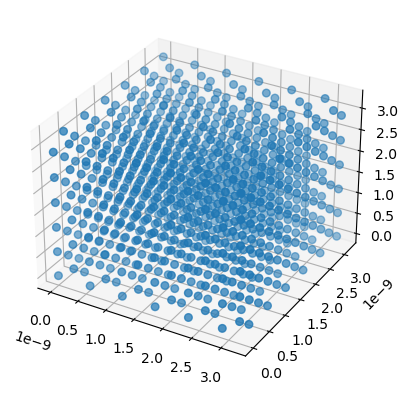

In [23]:
%matplotlib inline
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(*coords.T, s=30)

plt.show()

In [24]:
cur_coords, last_coords, cur_accl = init_coords(coords, combos, velo, L, delta_t)

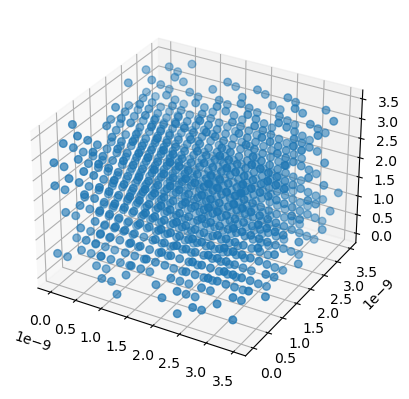

In [25]:
%matplotlib inline
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(*cur_coords.T, s=30)

plt.show()

In [26]:
cur_coords, last_coords, cur_accl, velocities = step(cur_coords, last_coords, delta_t, cur_accl, combos, L)

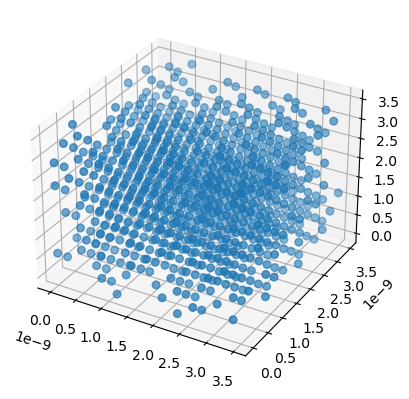

In [27]:
%matplotlib inline
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(*cur_coords.T, s=30)

plt.show()

In [1359]:
positions = []
all_velocities = []
cur_coords, last_coords, cur_accl = init_coords(coords, combos, velo, L, delta_t)
velocities = velo

In [1360]:
%%time
for i in range(1000):
    positions.append(cur_coords)
    all_velocities.append(velocities)
    cur_coords, last_coords, cur_accl, velocities = step(cur_coords, last_coords, delta_t, cur_accl, combos, L)

CPU times: user 1min 18s, sys: 3.22 s, total: 1min 21s
Wall time: 1min 21s


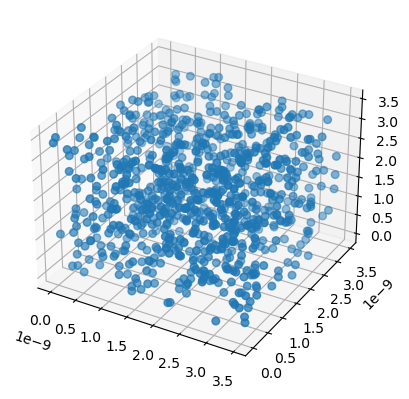

In [1486]:
%matplotlib inline
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(*positions[-1].T, s=30)

plt.show()

In [1368]:
means = []
for v in all_velocities:
    means.append(LA.norm(v, axis=1).mean())

In [1369]:
means

[1052.0271401737455,
 1051.9776931340882,
 651.1690125955494,
 250.3285273744807,
 1052.1206927817348,
 650.900004632562,
 651.0952747176633,
 1452.7638500210896,
 651.1540443848671,
 1452.8452205686772]

## Argon Simulator Script
The above code is written as a simulator class object in the file `ArgonSimulator.py`

In [166]:
import importlib
import ArgonSimulator
importlib.reload(ArgonSimulator)
from ArgonSimulator import ArgonSim

TypeError: class members are not yet supported: n, m_argon, m_argon_kg, kb, sigma, lennard_jones_cutoff

In [154]:
sim = ArgonSim(n_cells = 8, temp = 120)

In [155]:
%%time
coords = []
velocities = []
potentials = []
for i in range(500):
    coords.append(sim.coords)
    velocities.append(sim.velo)
    potentials.append(sim.get_potentials())
    sim.step()

CPU times: user 1min 28s, sys: 9.87 s, total: 1min 37s
Wall time: 1min 38s


In [156]:
kinetic_ener =(np.array(velocities)**2*sim.m_argon_kg/2).sum((1,2))
potential_ener = np.array(potentials).sum(1)

In [157]:
total = kinetic_ener+potential_ener

In [158]:
total.max(), total.mean(), total.std()

(6.936249182904503e-13, 8.922929019597606e-15, 3.1239128268702446e-14)

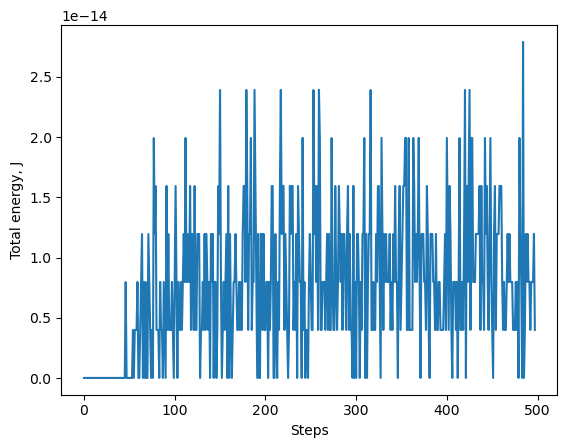

In [159]:
plt.plot(total[2:])
plt.xlabel('Steps')
plt.ylabel('Total energy, J')
plt.show()

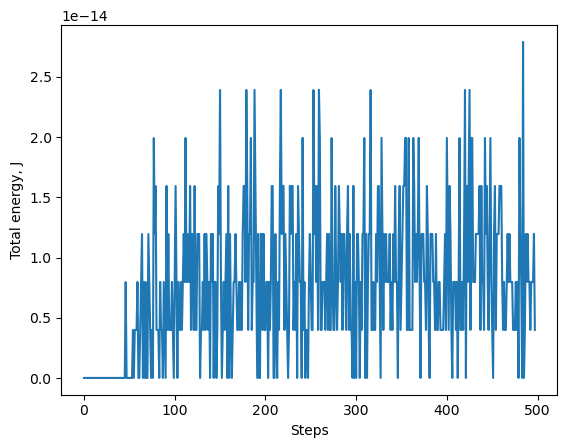

In [161]:
plt.plot(total[2:])
plt.xlabel('Steps')
plt.ylabel('Total energy, J')
# plt.ylim(0, 5e-9)
plt.show()

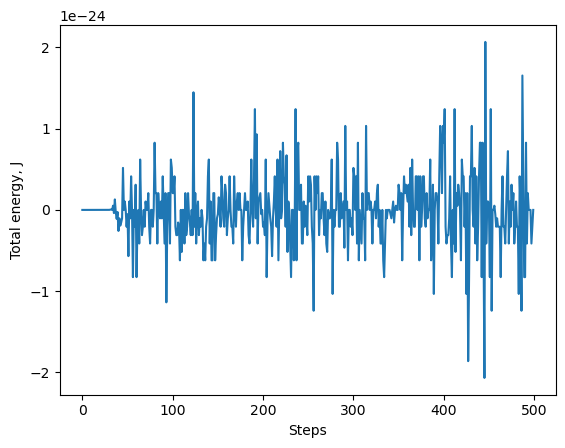

In [162]:
plt.plot(potential_ener)
plt.xlabel('Steps')
plt.ylabel('Total energy, J')
# plt.ylim(0, 5e-9)
plt.show()

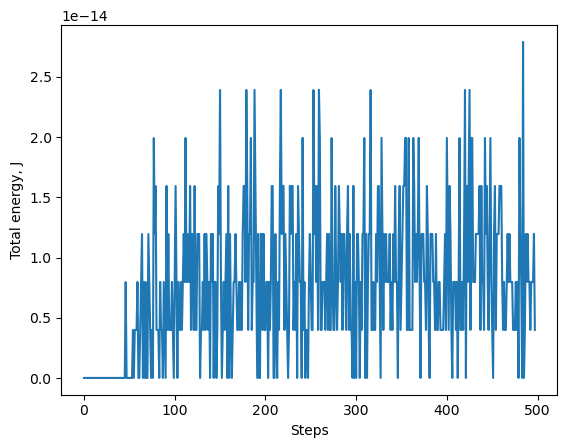

In [164]:
plt.plot(kinetic_ener[2:])
plt.xlabel('Steps')
plt.ylabel('Total energy, J')
# plt.ylim(0, 5e-9)
plt.show()